In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tensorflow.examples.tutorials.mnist import input_data

C:\Users\John\Anaconda3\envs\retro\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mnist.train.images.shape

(55000, 784)

In [4]:
784 ** .5

28.0

In [5]:
trainx = mnist.train.images

In [6]:
testx = mnist.test.images

In [7]:
trainy = mnist.train.labels

In [8]:
testy = mnist.test.labels

In [9]:
trainx.shape, testx.shape, trainy.shape, testy.shape

((55000, 784), (10000, 784), (55000, 10), (10000, 10))

In [10]:
trainx = trainx.reshape(-1, 1, 28, 28)
testx = testx.reshape(-1, 1, 28, 28)
trainx.shape, testx.shape

((55000, 1, 28, 28), (10000, 1, 28, 28))

In [11]:
class ResLayer(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, padding, stride = 1, num_resid = 3):
        super(ResLayer, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, padding = padding, stride = stride)
        self.res = nn.Conv2d(out_dim, out_dim, kernel_size, padding = padding)
        self.num_resid = num_resid
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        for _ in range(self.num_resid):
            x_conv = F.relu(self.res(x))
            x = F.relu(x + self.res(x_conv))
        
        return x

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = ResLayer(1, 32, 5, padding = 2)
        self.drop1 = nn.Dropout(.2)
        self.conv2 = ResLayer(32, 64, 5, padding = 2, stride = 2)
        self.drop2 = nn.Dropout(.3)
        self.conv3 = ResLayer(64, 128, 5, padding = 2, stride = 2)
        self.drop3 = nn.Dropout(.5)
        self.conv_out = nn.Conv2d(128, 10, 7, padding = 0)
        
        self.layers = nn.Sequential(self.conv1, self.drop1,
                                    self.conv2, self.drop2,
                                    self.conv3, self.drop3,
                                    self.conv_out, nn.Softmax(1))
    
    def forward(self, images):
        return self.layers(images).squeeze()

In [12]:
model = MNISTNet()
model(torch.FloatTensor(trainx[:5]))

tensor([[ 0.1022,  0.0971,  0.0987,  0.1006,  0.0980,  0.1122,  0.0902,
          0.1061,  0.0954,  0.0996],
        [ 0.1048,  0.0930,  0.1049,  0.1007,  0.0992,  0.1079,  0.0989,
          0.0974,  0.0958,  0.0974],
        [ 0.1008,  0.1020,  0.1021,  0.1045,  0.1049,  0.0998,  0.0961,
          0.0928,  0.0990,  0.0980],
        [ 0.1060,  0.0939,  0.0947,  0.0964,  0.1028,  0.1092,  0.0988,
          0.0962,  0.1016,  0.1004],
        [ 0.0985,  0.0925,  0.0985,  0.1034,  0.1012,  0.1116,  0.1012,
          0.0950,  0.0972,  0.1008]])

In [13]:
import numpy as np
from math import ceil

In [14]:
def training_data_generator(trainx, trainy, batch_size = 32, subsample_pct = 1):
    n_samples = trainx.shape[0]
    indexes = np.random.permutation(n_samples)
    n_samples_sub = int(n_samples * subsample_pct)
    indexes = indexes[:n_samples_sub]
    
    for i in range(ceil(n_samples_sub / batch_size)):
        start = i * batch_size
        end = (i + 1) * batch_size
        yield_indices = indexes[start:end]
        yield trainx[yield_indices], trainy[yield_indices]

In [34]:
def adjust_lr(optimizer, epoch, start_lr = .001):
    lr = start_lr * (0.9 ** epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [35]:
model = MNISTNet()
optimizer = torch.optim.Adam(model.parameters())

In [36]:
test_data = torch.FloatTensor(testx)
test_data_labels = torch.LongTensor(testy.argmax(1))

In [ ]:
for swa_run in range(10):
    print("SWA Run {}".format(swa_run))
    for epoch in range(10):
        losses = []
        test_losses = []
        lr = adjust_lr(optimizer, epoch)
        print(f"{epoch}: LR = {lr:.4f}")
        model.train()
        for batchx, batchy in training_data_generator(trainx, trainy, batch_size = 128, subsample_pct = .1):
            data = torch.FloatTensor(batchx).requires_grad_(True)
            labels = torch.LongTensor(batchy.argmax(1))
            output = model(data)
            loss = F.cross_entropy(output, labels)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        for batchx, batchy in training_data_generator(testx, testy, batch_size = 128, subsample_pct = .25):
            data = torch.FloatTensor(batchx)
            labels = torch.LongTensor(batchy.argmax(1))
            output = model(data)
            loss = F.cross_entropy(output, labels)
            test_losses.append(loss.item())
        print("Training loss: {}".format(np.mean(losses)))
        print("Testing loss: {}".format(np.mean(test_losses)))
    torch.save(model.state_dict(), open(f"swa_run{swa_run}.pth", "wb"))

SWA Run 0
0: LR = 0.0010
Training loss: 1.5259553914846375
Testing loss: 1.4909248888492583
1: LR = 0.0009
Training loss: 1.510747754296591
Testing loss: 1.494855946302414
2: LR = 0.0008
Training loss: 1.5038599690725638
Testing loss: 1.4875292301177978
3: LR = 0.0007
Training loss: 1.507502134456191
Testing loss: 1.4904719173908234
4: LR = 0.0007
Training loss: 1.5016566792199777
Testing loss: 1.4931854367256165
5: LR = 0.0006
Training loss: 1.491364789563556
Testing loss: 1.4880838990211487
6: LR = 0.0005
Training loss: 1.491385446038357
Testing loss: 1.4863834857940674
7: LR = 0.0005
Training loss: 1.48805673732314
Testing loss: 1.4829363763332366
8: LR = 0.0004
Training loss: 1.4890346721161243
Testing loss: 1.4760433971881866
9: LR = 0.0004
Training loss: 1.4890114651169888
Testing loss: 1.4812898695468903
SWA Run 1
0: LR = 0.0010
Training loss: 1.4937098442121994
Testing loss: 1.495544159412384
1: LR = 0.0009


In [40]:
model(torch.FloatTensor(trainx[:5])).max(1), trainy.argmax(1)

((tensor([ 0.9998,  0.9999,  1.0000,  1.0000,  1.0000]),
  tensor([ 7,  3,  4,  6,  1])),
 array([7, 3, 4, ..., 5, 6, 8], dtype=int64))

In [56]:
def batch_predict(testx, batch_size = 128):
    outputs = []
    for i in range(ceil(len(testx) / batch_size)):
        data = torch.FloatTensor(testx[i * batch_size : (i + 1) * batch_size])
        preds = model(data)
        outputs.append(preds.detach().numpy())
    return outputs

preds = batch_predict(testx)

In [57]:
preds = np.concatenate(preds)
preds.shape

(10000, 10)

In [58]:
preds[0]

array([2.0819091e-40, 2.9688711e-35, 2.0341120e-24, 3.8765137e-27,
       3.9956624e-41, 1.2994479e-39, 0.0000000e+00, 1.0000000e+00,
       1.0605987e-31, 1.1210813e-27], dtype=float32)

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

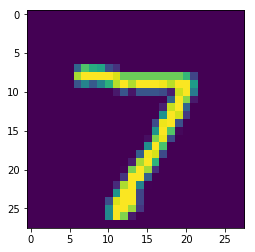

In [60]:
plt.imshow(testx[0].squeeze())

In [61]:
np.mean(preds.argmax(1) == testy.argmax(1))

0.9705

9: LR = 0.0004  
Training loss: 1.6006645130556683  
Testing loss: 1.5895625472068786

In [53]:
np.mean(preds.argmax(1) == testy.argmax(1))

0.8717

In [62]:
torch.save(model.state_dict(), open("baseline.pth", "wb"))